In [108]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm
import lightgbm as lgb
from sklearn import preprocessing
import sklearn
import datetime
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from imblearn.over_sampling import SVMSMOTE, SMOTE
from sklearn.metrics import roc_auc_score, f1_score, classification_report


In [109]:
coupon_area_train = pd.read_csv('./coupon-purchase-prediction/coupon_area_train.csv')
coupon_detail_train = pd.read_csv('./coupon-purchase-prediction/coupon_detail_train.csv')
coupon_list_train = pd.read_csv('./coupon-purchase-prediction/coupon_list_train.csv')
coupon_visit_train = pd.read_csv('./coupon-purchase-prediction/coupon_visit_train.csv')
prefecture_locations = pd.read_csv('./coupon-purchase-prediction/prefecture_locations.csv')
sample_submission = pd.read_csv('./coupon-purchase-prediction/sample_submission.csv')
user_list = pd.read_csv('./coupon-purchase-prediction/user_list.csv')

In [195]:
coupon_area_test = pd.read_csv('./coupon-purchase-prediction/coupon_area_test.csv')
coupon_list_test = pd.read_csv('./coupon-purchase-prediction/coupon_list_test.csv')

In [17]:
coupon_area_test.shape

(2165, 3)

In [18]:
coupon_area_test.head()

,SMALL_AREA_NAME,PREF_NAME,COUPON_ID_hash
0,京都,京都府,c76ea297ebd3a5a4d3bf9f75269f66fa
1,ミナミ他,大阪府,c76ea297ebd3a5a4d3bf9f75269f66fa
2,銀座・新橋・東京・上野,東京都,dd74dc95ca294afa02db40a543ae1763
3,川崎・湘南・箱根他,神奈川県,c65b550cbef918796ad53b1d5b7165c1
4,埼玉,埼玉県,c65b550cbef918796ad53b1d5b7165c1


In [19]:
coupon_area_train.head()

,SMALL_AREA_NAME,PREF_NAME,COUPON_ID_hash
0,埼玉,埼玉県,6b263844241eea98c5a97f1335ea82af
1,千葉,千葉県,cc031f250e8bad1e24060263b9fc0ddd
2,千葉,千葉県,ba5e9b7453ca52ff711635a5d2e8102d
3,千葉,千葉県,3e1ffbedca3569f9e8032d401e8cb4e6
4,千葉,千葉県,782934b6c815b4030ea204eef7d4a734


In [20]:
coupon_detail_train.head()

,ITEM_COUNT,I_DATE,SMALL_AREA_NAME,PURCHASEID_hash,USER_ID_hash,COUPON_ID_hash
0,1,2012-03-28 15:06:06,兵庫,c820a8882374a4e472f0984a8825893f,d9dca3cb44bab12ba313eaa681f663eb,34c48f84026e08355dc3bd19b427f09a
1,1,2011-07-04 23:52:54,銀座・新橋・東京・上野,1b4eb2435421ede98c8931c42e8220ec,560574a339f1b25e57b0221e486907ed,767673b7a777854a92b73b0934ddfae7
2,1,2011-07-16 00:52:49,恵比寿・目黒・品川,36b5f9ba46c44b65587d0b16f2e4c77f,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
3,1,2011-07-16 00:54:53,恵比寿・目黒・品川,2f30f46937cc9004774e576914b2aa1a,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
4,1,2011-07-16 00:55:52,恵比寿・目黒・品川,4d000c64a55ac573d0ae1a8f03677f50,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2


In [21]:
coupon_detail_train.columns

Index(['ITEM_COUNT', 'I_DATE', 'SMALL_AREA_NAME', 'PURCHASEID_hash',
       'USER_ID_hash', 'COUPON_ID_hash'],
      dtype='object')

In [22]:
coupon_list_test.head()

,CAPSULE_TEXT,GENRE_NAME,PRICE_RATE,CATALOG_PRICE,DISCOUNT_PRICE,DISPFROM,DISPEND,DISPPERIOD,VALIDFROM,VALIDEND,...,USABLE_DATE_THU,USABLE_DATE_FRI,USABLE_DATE_SAT,USABLE_DATE_SUN,USABLE_DATE_HOLIDAY,USABLE_DATE_BEFORE_HOLIDAY,large_area_name,ken_name,small_area_name,COUPON_ID_hash
0,グルメ,グルメ,52,5659,2690,2012-06-26 12:00:00,2012-06-30 12:00:00,4,2012-07-01,2012-10-27,...,1.0,1.0,1.0,1.0,1.0,1.0,関西,大阪府,ミナミ他,c76ea297ebd3a5a4d3bf9f75269f66fa
1,グルメ,グルメ,52,18000,8500,2012-06-27 12:00:00,2012-07-04 12:00:00,7,2012-07-05,2012-10-13,...,1.0,1.0,1.0,0.0,0.0,1.0,関東,東京都,銀座・新橋・東京・上野,dd74dc95ca294afa02db40a543ae1763
2,グルメ,グルメ,51,7200,3480,2012-06-28 12:00:00,2012-07-05 12:00:00,7,2012-07-06,2012-12-28,...,1.0,1.0,1.0,1.0,1.0,1.0,関東,神奈川県,横浜,c65b550cbef918796ad53b1d5b7165c1
3,グルメ,グルメ,50,3300,1650,2012-06-24 12:00:00,2012-06-29 12:00:00,5,2012-06-30,2012-10-31,...,1.0,2.0,2.0,1.0,1.0,2.0,関西,兵庫県,兵庫,f93dc6e223935d817e1237f8f73b56a2
4,グルメ,グルメ,56,3650,1600,2012-06-26 12:00:00,2012-07-03 12:00:00,7,2012-07-04,2012-11-10,...,1.0,1.0,1.0,1.0,1.0,1.0,東海,愛知県,愛知,86c64391318f1d751647bf8e1882cf1d


In [146]:
print(list(zip(sorted(coupon_list_train['ken_name'].unique()),sorted(prefecture_locations['PREF_NAME'].unique()))))

[('三重県', '三重県'), ('京都府', '京都府'), ('佐賀県', '佐賀県'), ('兵庫県', '兵庫県'), ('北海道', '北海道'), ('千葉県', '千葉県'), ('和歌山県', '和歌山県'), ('埼玉県', '埼玉県'), ('大分県', '大分県'), ('大阪府', '大阪府'), ('奈良県', '奈良県'), ('宮城県', '宮城県'), ('宮崎県', '宮崎県'), ('富山県', '富山県'), ('山口県', '山口県'), ('山形県', '山形県'), ('山梨県', '山梨県'), ('岐阜県', '岐阜県'), ('岡山県', '岡山県'), ('岩手県', '岩手県'), ('島根県', '島根県'), ('広島県', '広島県'), ('徳島県', '徳島県'), ('愛媛県', '愛媛県'), ('愛知県', '愛知県'), ('新潟県', '新潟県'), ('東京都', '東京都'), ('栃木県', '栃木県'), ('沖縄県', '沖縄県'), ('滋賀県', '滋賀県'), ('熊本県', '熊本県'), ('石川県', '石川県'), ('神奈川県', '神奈川県'), ('福井県', '福井県'), ('福岡県', '福岡県'), ('福島県', '福島県'), ('秋田県', '秋田県'), ('群馬県', '群馬県'), ('茨城県', '茨城県'), ('長崎県', '長崎県'), ('長野県', '長野県'), ('青森県', '青森県'), ('静岡県', '静岡県'), ('香川県', '香川県'), ('高知県', '高知県'), ('鳥取県', '鳥取県'), ('鹿児島県', '鹿児島県')]


In [149]:
'埼玉県' in prefecture_locations['PREF_NAME'].unique()

True

In [23]:
coupon_list_test.columns

Index(['CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'large_area_name', 'ken_name',
       'small_area_name', 'COUPON_ID_hash'],
      dtype='object')

In [24]:
coupon_list_train.head()

,CAPSULE_TEXT,GENRE_NAME,PRICE_RATE,CATALOG_PRICE,DISCOUNT_PRICE,DISPFROM,DISPEND,DISPPERIOD,VALIDFROM,VALIDEND,...,USABLE_DATE_THU,USABLE_DATE_FRI,USABLE_DATE_SAT,USABLE_DATE_SUN,USABLE_DATE_HOLIDAY,USABLE_DATE_BEFORE_HOLIDAY,large_area_name,ken_name,small_area_name,COUPON_ID_hash
0,グルメ,グルメ,50,3000,1500,2011-07-08 12:00:00,2011-07-09 12:00:00,1,2011-07-10,2011-12-08,...,1.0,0.0,0.0,1.0,1.0,0.0,関東,埼玉県,埼玉,6b263844241eea98c5a97f1335ea82af
1,グルメ,グルメ,51,2080,1000,2011-07-01 12:00:00,2011-07-02 12:00:00,1,2011-07-03,2011-12-04,...,1.0,1.0,1.0,1.0,1.0,1.0,関東,千葉県,千葉,cc031f250e8bad1e24060263b9fc0ddd
2,グルメ,グルメ,50,7000,3500,2011-07-12 12:00:00,2011-07-15 12:00:00,3,2011-07-16,2012-01-11,...,1.0,1.0,1.0,1.0,1.0,1.0,関東,千葉県,千葉,ba5e9b7453ca52ff711635a5d2e8102d
3,グルメ,グルメ,50,3000,1500,2011-07-09 12:00:00,2011-07-11 12:00:00,2,2011-07-12,2011-12-01,...,1.0,0.0,0.0,1.0,1.0,1.0,関東,千葉県,千葉,3e1ffbedca3569f9e8032d401e8cb4e6
4,グルメ,グルメ,50,2000,1000,2011-07-05 12:00:00,2011-07-06 12:00:00,1,2011-07-07,2011-12-30,...,1.0,0.0,0.0,1.0,1.0,0.0,関東,千葉県,千葉,782934b6c815b4030ea204eef7d4a734


In [25]:
coupon_visit_train.head()

,PURCHASE_FLG,I_DATE,PAGE_SERIAL,REFERRER_hash,VIEW_COUPON_ID_hash,USER_ID_hash,SESSION_ID_hash,PURCHASEID_hash
0,0,2012-03-28 14:15:00,7,7d3892e54acb559ae36c459978489330,34c48f84026e08355dc3bd19b427f09a,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,NaN
1,0,2012-03-28 14:17:28,9,7d3892e54acb559ae36c459978489330,34c48f84026e08355dc3bd19b427f09a,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,NaN
2,0,2012-03-28 14:20:05,16,7d3892e54acb559ae36c459978489330,17c450c3b470c045d35ec22b02daa690,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,NaN
3,0,2012-03-28 14:23:16,18,7d3892e54acb559ae36c459978489330,91a15e6a95d09e5e01b50747833b317d,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,NaN
4,0,2012-03-28 14:26:25,20,7d3892e54acb559ae36c459978489330,96fcbc8f6e45d5a2de1661eb140c6e82,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,NaN


In [26]:
coupon_purchased = coupon_visit_train.PURCHASEID_hash.unique()
len(coupon_purchased)

114775

In [13]:
prefecture_locations.head()

,PREF_NAME,PREFECTUAL_OFFICE,LATITUDE,LONGITUDE
0,北海道,札幌市,43.063968,141.347899
1,青森県,青森市,40.824623,140.740593
2,岩手県,盛岡市,39.703531,141.152667
3,宮城県,仙台市,38.268839,140.872103
4,秋田県,秋田市,39.718600,140.102334


In [14]:
sample_submission.head()

,USER_ID_hash,PURCHASED_COUPONS
0,0000b53e182165208887ba65c079fc21,NaN
1,00035b86e6884589ec8d28fbf2fe7757,NaN
2,0005b1068d5f2b8f2a7c978fcfe1ca06,NaN
3,000cc06982785a19e2a2fdb40b1c9d59,NaN
4,0013518e41c416cd6a181d277dd8ca0b,NaN


In [15]:
user_list.head()

,REG_DATE,SEX_ID,AGE,WITHDRAW_DATE,PREF_NAME,USER_ID_hash
0,2012-03-28 14:14:18,f,25,NaN,NaN,d9dca3cb44bab12ba313eaa681f663eb
1,2011-05-18 00:41:48,f,34,NaN,東京都,560574a339f1b25e57b0221e486907ed
2,2011-06-13 16:36:58,m,41,NaN,愛知県,e66ae91b978b3229f8fd858c80615b73
3,2012-02-08 12:56:15,m,25,NaN,NaN,43fc18f32eafb05713ec02935e2c2825
4,2011-05-22 23:43:56,m,62,NaN,神奈川県,dc6df8aa860f8db0d710ce9d4839840f


In [16]:
user_list.columns

Index(['REG_DATE', 'SEX_ID', 'AGE', 'WITHDRAW_DATE', 'PREF_NAME',
       'USER_ID_hash'],
      dtype='object')

In [100]:
model = LogisticRegression(random_state=0).fit(train_x, train_y)
prediction = model.predict(train_x)

In [43]:
model.predict_proba(train_x)

array([[0.95946523, 0.04053477],
       [0.95946523, 0.04053477],
       [0.95946523, 0.04053477],
       ...,
       [0.94878797, 0.05121203],
       [0.94878797, 0.05121203],
       [0.95370281, 0.04629719]])

In [44]:
model.score(train_x, train_y)

0.9513790289710099

In [96]:
# test_x = pd.DataFrame(columns=['PRICE_RATE', 'COUPON_ID_hash', 'SEX_ID', 'USER_ID_hash'])
test_x = []
for i in tqdm(coupon_list_test.iterrows(), total=len(coupon_list_test)):
    for j in user_list.iterrows():
        x = pd.concat([i[1][['PRICE_RATE', 'COUPON_ID_hash']],j[1][['SEX_ID', 'USER_ID_hash']]])
#         test_x = test_x.append(x, ignore_index=True)
        test_x.append(x)
test_x = pd.DataFrame(test_x)

  0%|          | 0/310 [00:00<?, ?it/s]

In [97]:
test_x.head()

,PRICE_RATE,COUPON_ID_hash,SEX_ID,USER_ID_hash
0,52,c76ea297ebd3a5a4d3bf9f75269f66fa,f,d9dca3cb44bab12ba313eaa681f663eb
Unnamed 0,52,c76ea297ebd3a5a4d3bf9f75269f66fa,f,560574a339f1b25e57b0221e486907ed
Unnamed 1,52,c76ea297ebd3a5a4d3bf9f75269f66fa,m,e66ae91b978b3229f8fd858c80615b73
Unnamed 2,52,c76ea297ebd3a5a4d3bf9f75269f66fa,m,43fc18f32eafb05713ec02935e2c2825
Unnamed 3,52,c76ea297ebd3a5a4d3bf9f75269f66fa,m,dc6df8aa860f8db0d710ce9d4839840f


In [75]:
test_x

,PRICE_RATE,COUPON_ID_hash,SEX_ID,USER_ID_hash


In [99]:
test_x.set_index(['COUPON_ID_hash', 'USER_ID_hash'], inplace = True)

In [102]:
test_x['SEX_ID'][test_x['SEX_ID']=='m'] = 1
test_x['SEX_ID'][test_x['SEX_ID']=='f'] = 0

<ipython-input-102-9e97ad19b14e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['SEX_ID'][test_x['SEX_ID']=='m'] = 1
<ipython-input-102-9e97ad19b14e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['SEX_ID'][test_x['SEX_ID']=='f'] = 0


In [114]:
sample_submission.head()

,USER_ID_hash,PURCHASED_COUPONS
0,0000b53e182165208887ba65c079fc21,NaN
1,00035b86e6884589ec8d28fbf2fe7757,NaN
2,0005b1068d5f2b8f2a7c978fcfe1ca06,NaN
3,000cc06982785a19e2a2fdb40b1c9d59,NaN
4,0013518e41c416cd6a181d277dd8ca0b,NaN


In [194]:
test_X.head()

,COUPON_ID_hash,USER_ID_hash,PRICE_RATE,SEX_ID
0,c76ea297ebd3a5a4d3bf9f75269f66fa,d9dca3cb44bab12ba313eaa681f663eb,52,0
1,c76ea297ebd3a5a4d3bf9f75269f66fa,560574a339f1b25e57b0221e486907ed,52,0
2,c76ea297ebd3a5a4d3bf9f75269f66fa,e66ae91b978b3229f8fd858c80615b73,52,1
3,c76ea297ebd3a5a4d3bf9f75269f66fa,43fc18f32eafb05713ec02935e2c2825,52,1
4,c76ea297ebd3a5a4d3bf9f75269f66fa,dc6df8aa860f8db0d710ce9d4839840f,52,1


In [252]:
test_X = test_x.reset_index()
for row in tqdm(sample_submission.iterrows(), total = len(sample_submission)):
    idx = pred[test_X['USER_ID_hash'] == row[1]['USER_ID_hash']][:,1].argsort()[-10:]
#     coupon_ids = test_X['COUPON_ID_hash'][test_X['USER_ID_hash'] == row[1]['USER_ID_hash']].reset_index().iloc[idx]['COUPON_ID_hash']
    coupon_ids = coupon_list_test['COUPON_ID_hash'].iloc[idx]
    sample_submission['PURCHASED_COUPONS'][sample_submission['USER_ID_hash'] == row[1]['USER_ID_hash']] = ', '.join(coupon_ids)


  0%|          | 0/22873 [00:00<?, ?it/s]

In [253]:
sample_submission.head()

,USER_ID_hash,PURCHASED_COUPONS
0,0000b53e182165208887ba65c079fc21,"f8cd0c285f925936e2ef808eb3a8296a, b47340cbd4f4..."
1,00035b86e6884589ec8d28fbf2fe7757,"f8cd0c285f925936e2ef808eb3a8296a, b47340cbd4f4..."
2,0005b1068d5f2b8f2a7c978fcfe1ca06,"f8cd0c285f925936e2ef808eb3a8296a, b47340cbd4f4..."
3,000cc06982785a19e2a2fdb40b1c9d59,"f8cd0c285f925936e2ef808eb3a8296a, b47340cbd4f4..."
4,0013518e41c416cd6a181d277dd8ca0b,"f8cd0c285f925936e2ef808eb3a8296a, b47340cbd4f4..."


In [239]:
#', '.join(coupons.reset_index().iloc[idx]['COUPON_ID_hash'])

'f8cd0c285f925936e2ef808eb3a8296a, b47340cbd4f4c57f32637cfb86462cc3, 64b92e53b6e56f7f7bd158ec31887f3d, 16eb5a39ed9efd47cedbfdf8985df147, 9e22b913cb077f8ef844112bcfc72787, 53e6af8b95c14358a345910643a85382, 3ac97c8d840663c600471b44895dc4c0, 784c1314b9f64ae9f3c6e217fb10d15c, 96d275611439e0029db651a914965ea3, c988d799bc7db9254fe865ee6cf2d4ff'

In [254]:
sample_submission.to_csv('result.csv', index=False)

#  ************************
#   ****************
# ************************


In [178]:
def getTrainData(user_list, coupon_list_train, coupon_visit_train):
    user_features = user_list[['REG_DATE', 'SEX_ID', 'AGE', 'PREF_NAME', 'USER_ID_hash']]
    coupon_features = coupon_list_train[['CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'large_area_name', 'ken_name',
       'small_area_name', 'COUPON_ID_hash']]
    prev = user_features.merge(coupon_visit_train, on = 'USER_ID_hash')
    prev = coupon_features.merge(prev, left_on = 'COUPON_ID_hash', right_on = 'VIEW_COUPON_ID_hash')
    trainData = prev[['PURCHASE_FLG','CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'large_area_name', 'ken_name',
       'small_area_name', 'COUPON_ID_hash', 'REG_DATE', 'SEX_ID', 'AGE',
       'PREF_NAME', 'USER_ID_hash']]
    trainData.dropna(inplace = True)
    trainData.set_index(['COUPON_ID_hash','USER_ID_hash'], inplace = True)
    #train_y = train_x.pop('PURCHASE_FLG')
    return trainData

In [120]:
trainData.head()

PURCHASE_FLG  \
COUPON_ID_hash                   USER_ID_hash                                     
6b263844241eea98c5a97f1335ea82af 6c3cbc5c3db3c673ffb52cd946dce194             0   
                                 6c3cbc5c3db3c673ffb52cd946dce194             0   
                                 6c3cbc5c3db3c673ffb52cd946dce194             0   
                                 cdeb7bb2ba2fb35aa988a78f2aac1ff1             0   
                                 48363bdca9fdfa03f93b1814414dc69f             0   

                                                                  CAPSULE_TEXT  \
COUPON_ID_hash                   USER_ID_hash                                    
6b263844241eea98c5a97f1335ea82af 6c3cbc5c3db3c673ffb52cd946dce194           10   
                                 6c3cbc5c3db3c673ffb52cd946dce194           10   
                                 6c3cbc5c3db3c673ffb52cd946dce194           10   
                                 cdeb7bb2ba2fb35aa988a78f2aac1ff1           10   
                                 48363bdca9fdfa03f93b1814414dc69f           10   

                                                                  GENRE_NAME  \
COUPON_ID_hash                   USER_ID_hash                                  
6b263844241eea98c5a97f1335ea82af 6c3cbc5c3db3c673ffb52cd946dce194         10   
                                 6c3cbc5c3db3c673ffb52cd946dce194         10   
                                 6c3cbc5c3db3c673ffb52cd946dce194         10   
                                 cdeb7bb2ba2fb35aa988a78f2aac1ff1         10   
                                 48363bdca9fdfa03f93b1814414dc69f         10   

                                                                   PRICE_RATE  \
COUPON_ID_hash                   USER_ID_hash                                   
6b263844241eea98c5a97f1335ea82af 6c3cbc5c3db3c673ffb52cd946dce194          50   
                                 6c3cbc5c3db3c673ffb52cd946dce194          50   
                                 6c3cbc5c3db3c673ffb52cd946dce194          50   
                                 cdeb7bb2ba2fb35aa988a78f2aac1ff1          50   
                                 48363bdca9fdfa03f93b1814414dc69f          50   

                                                                   CATALOG_PRICE  \
COUPON_ID_hash                   USER_ID_hash                                      
6b263844241eea98c5a97f1335ea82af 6c3cbc5c3db3c673ffb52cd946dce194           3000   
                                 6c3cbc5c3db3c673ffb52cd946dce194           3000   
                                 6c3cbc5c3db3c673ffb52cd946dce194           3000   
                                 cdeb7bb2ba2fb35aa988a78f2aac1ff1           3000   
                                 48363bdca9fdfa03f93b1814414dc69f           3000   

                                                                   DISCOUNT_PRICE  \
COUPON_ID_hash                   USER_ID_hash                                       
6b263844241eea98c5a97f1335ea82af 6c3cbc5c3db3c673ffb52cd946dce194            1500   
                                 6c3cbc5c3db3c673ffb52cd946dce194            1500   
                                 6c3cbc5c3db3c673ffb52cd946dce194            1500   
                                 cdeb7bb2ba2fb35aa988a78f2aac1ff1            1500   
                                 48363bdca9fdfa03f93b1814414dc69f            1500   

                                                                       DISPFROM  \
COUPON_ID_hash                   USER_ID_hash                                     
6b263844241eea98c5a97f1335ea82af 6c3cbc5c3db3c673ffb52cd946dce194  1.310152e+09   
                                 6c3cbc5c3db3c673ffb52cd946dce194  1.310152e+09   
                                 6c3cbc5c3db3c673ffb52cd946dce194  1.310152e+09   
                                 cdeb7bb2ba2fb35aa988a78f2aac1ff1  1.310152e+09   
                                 48363bdca9fdfa03f93b1814414dc69f  1.310152e+09   

              

In [188]:
trainData = getTrainData(user_list, coupon_list_train, coupon_visit_train)

<ipython-input-178-87cf79b354ec>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainData.dropna(inplace = True)


In [220]:
def calculate_euclidean_dist(start,end):
    p = prefecture_locations[prefecture_locations['PREF_NAME'] == start]
    q = prefecture_locations[prefecture_locations['PREF_NAME'] == end]
    if len(p) + len(q) == 2: 
        return np.sqrt((p['LATITUDE'].values - q['LATITUDE'].values)**2 + (p['LONGITUDE'].values - q['LONGITUDE'].values)**2)[0]
    return np.nan

In [216]:

user_coupon_dist = []
dist_dict = {}
for row in tqdm(trainData.iterrows(), total = len(trainData)):
    ken_name = row[1]['ken_name']
    pref_name = row[1]['PREF_NAME']
    if not (ken_name, pref_name) in dist_dict:
        dist_dict[(ken_name, pref_name)] = (calculate_euclidean_dist(ken_name, pref_name))
        dist_dict[(pref_name, ken_name)] = dist_dict[(ken_name, pref_name)]
    euclidean_dist = dist_dict[(ken_name, pref_name)]
    user_coupon_dist.append(euclidean_dist)
trainData['EucliD'] = user_coupon_dist

  0%|          | 0/1243831 [00:00<?, ?it/s]

[]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [189]:
def processTime(X):
    dates = ['DISPFROM', 'DISPEND', 'VALIDFROM', 'VALIDEND', 'REG_DATE']
    for date_cat in dates:
        X[date_cat] = list(map(lambda y:np.nan if str(y) == 'nan' else y.timestamp(), map(lambda x:np.nan if str(x) == 'nan' else datetime.datetime.fromisoformat(x), X[date_cat])))
    return X

categories = ['CAPSULE_TEXT', 'GENRE_NAME', 'large_area_name', 'ken_name', 'small_area_name', 'SEX_ID', 'PREF_NAME']
def processData(X):
    cat_encoder_dict = {}
    for category in tqdm(categories):
        cat_encoder_dict[category] = {}
        counter = 0
        for cat in list(set(X[category])):
            cat_encoder_dict[category][cat] = counter
            X[category][X[category]==cat] = counter
            counter += 1
    return X, cat_encoder_dict


In [190]:
trainData = processTime(trainData)
trainData, cat_encoder_dict = processData(trainData)

  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-189-da41797d7992>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[category][X[category]==cat] = counter


In [165]:
trainData['EucliD'][:100]

COUPON_ID_hash                    USER_ID_hash                    
6b263844241eea98c5a97f1335ea82af  6c3cbc5c3db3c673ffb52cd946dce194    0.537329
                                  6c3cbc5c3db3c673ffb52cd946dce194    0.537329
                                  6c3cbc5c3db3c673ffb52cd946dce194    0.537329
                                  cdeb7bb2ba2fb35aa988a78f2aac1ff1    0.000000
                                  48363bdca9fdfa03f93b1814414dc69f    0.000000
                                                                        ...   
ba5e9b7453ca52ff711635a5d2e8102d  04fbb09184583c6bc1def69fa72d7f4e    0.439791
                                  d5af8e0cf27f1f5a98e989774e506abe    0.439791
                                  51ff6b5ccfe7a2b2b2342aad6645cf66    0.439791
                                  d29c79de3d92d04bbb7af780f62918c9    0.439791
                                  841e0bb455e6ab87269b9d7b577cf46e    0.000000
Name: EucliD, Length: 100, dtype: float64

In [170]:
kf = KFold(n_splits = 5)
results = []
y_truth = []
for train, test in kf.split(trainData):
    traindf = trainData.iloc[train]
    testdf = trainData.iloc[test]
    y_train = traindf.pop('PURCHASE_FLG')
    x_train = traindf
    y_test = testdf.pop('PURCHASE_FLG')
    x_test = testdf
    X_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)
    train_data = lgb.Dataset(X_resampled.values, label = list(y_resampled.values),feature_name=list(X_resampled.columns), categorical_feature=categories)
    param = {}
    param['num_leaves'] = 5
    param['objective'] = 'binary'
    param['metric'] = 'auc'
    # more num, easier overfit
    param['max_depth'] = 4
    # more num, harder overfit
    # param['min_data_in_leaf'] = 10
    # param['feature_pre_filter'] = False
    param['bagging_fraction'] = .6
    param['feature_fraction'] = .6
    param['feature_fraction_bynode'] = .6
    param['lambda_l1'] = .01
    param['lambda_l2'] = .01
    param['learning_rate'] = 0.01
    num_round = 500
    bst = lgb.train(param, train_data, num_round)
    result = bst.predict(x_test.values)
    results.extend(result)
    y_truth.extend(y_test)

/Users/lifangshi/miniconda3/envs/coupon_purchase_prediction/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 962994, number of negative: 962994
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4934
[LightGBM] [Info] Number of data points in the train set: 1925988, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/lifangshi/miniconda3/envs/coupon_purchase_prediction/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 961960, number of negative: 961960
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4918
[LightGBM] [Info] Number of data points in the train set: 1923920, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/lifangshi/miniconda3/envs/coupon_purchase_prediction/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 961663, number of negative: 961663
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4938
[LightGBM] [Info] Number of data points in the train set: 1923326, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/lifangshi/miniconda3/envs/coupon_purchase_prediction/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 961623, number of negative: 961623
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4933
[LightGBM] [Info] Number of data points in the train set: 1923246, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/lifangshi/miniconda3/envs/coupon_purchase_prediction/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 962368, number of negative: 962368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4939
[LightGBM] [Info] Number of data points in the train set: 1924736, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [167]:
roc_auc_score(y_truth, results)

0.5942034258659119

In [168]:
f1_score(y_truth, (np.array(results)>0.5) * 1)

0.06519755207214945

In [24]:
print(classification_report(y_truth, (np.array(results)>0.5) * 1))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94   1202652
           1       0.04      0.12      0.07     41179

    accuracy                           0.89   1243831
   macro avg       0.51      0.52      0.50   1243831
weighted avg       0.94      0.89      0.91   1243831



In [171]:
print(classification_report(y_truth, (np.array(results)>0.5) * 1))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95   1202652
           1       0.06      0.13      0.08     41179

    accuracy                           0.90   1243831
   macro avg       0.51      0.53      0.51   1243831
weighted avg       0.94      0.90      0.92   1243831



In [28]:
trainData['CAPSULE_TEXT'].unique()

array([10, 2, 5, 11, 3, 19, 0, 17, 9, 21, 13, 15, 14, 6, 20, 12, 8, 7, 4,
       16, 18, 1], dtype=object)

In [294]:
test_pred = bst.predict(test_x.values)
sns.histplot(test_pred)

/Users/lifangshi/miniconda3/envs/coupon_purchase_prediction/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 1202652, number of negative: 1202652
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4698
[LightGBM] [Info] Number of data points in the train set: 2405304, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [204]:
def getTestData(coupon_list_test, user_list):
    test_x = []
    for i in tqdm(coupon_list_test.iterrows(), total=len(coupon_list_test)):
        for j in user_list.iterrows():
            x = pd.concat([i[1][['CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
           'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
           'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
           'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
           'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
           'USABLE_DATE_BEFORE_HOLIDAY', 'large_area_name', 'ken_name',
           'small_area_name', 'COUPON_ID_hash']], j[1][['REG_DATE', 'SEX_ID', 'AGE', 'PREF_NAME', 'USER_ID_hash']]])
            test_x.append(x)
    test_x = pd.DataFrame(test_x)
    test_x.set_index(['COUPON_ID_hash', 'USER_ID_hash'], inplace = True)
    return test_x

In [210]:
test_x = getTestData(coupon_list_test, user_list)
test_x = processTime(test_x)

  0%|          | 0/310 [00:00<?, ?it/s]

In [221]:
user_coupon_dist = []
for row in tqdm(test_x.iterrows(), total = len(test_x)):
    ken_name = row[1]['ken_name']
    pref_name = row[1]['PREF_NAME']
    if not (ken_name, pref_name) in dist_dict:
        dist_dict[(ken_name, pref_name)] = (calculate_euclidean_dist(ken_name, pref_name))
        dist_dict[(pref_name, ken_name)] = dist_dict[(ken_name, pref_name)]
    euclidean_dist = dist_dict[(ken_name, pref_name)]
    user_coupon_dist.append(euclidean_dist)

test_x['EucliD'] = user_coupon_dist

  0%|          | 0/7090630 [00:00<?, ?it/s]

In [206]:
def processTestData(X):
    for category in tqdm(categories):
        for cat in list(set(X[category])):
            if cat in cat_encoder_dict[category]:
                X[category][X[category] == cat] = cat_encoder_dict[category][cat]
            else:
                X[category][X[category] == cat] = np.nan
    return X


In [222]:
test_x = processTestData(test_x)

  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-206-5d6753ed57a9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[category][X[category] == cat] = cat_encoder_dict[category][cat]
<ipython-input-206-5d6753ed57a9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[category][X[category] == cat] = np.nan


In [223]:
test_pred = bst.predict(test_x.values)

In [290]:
test_pred[:10]

array([0.97579541, 0.98137921, 0.96631322, 0.97261231, 0.9871732 ,
       0.9866257 , 0.98168493, 0.96507214, 0.97558641, 0.97261231])

In [226]:
test_X = test_x.reset_index()
for row in tqdm(sample_submission.iterrows(), total = len(sample_submission)):
    idx = test_pred[test_X['USER_ID_hash'] == row[1]['USER_ID_hash']].argsort()[-10:]
    coupon_ids = coupon_list_test['COUPON_ID_hash'].iloc[idx]
    sample_submission['PURCHASED_COUPONS'][sample_submission['USER_ID_hash'] == row[1]['USER_ID_hash']] = ', '.join(coupon_ids)
sample_submission.to_csv('result.csv', index = False)

  0%|          | 0/22873 [00:00<?, ?it/s]

<ipython-input-226-1a1b2913f287>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_submission['PURCHASED_COUPONS'][sample_submission['USER_ID_hash'] == row[1]['USER_ID_hash']] = ', '.join(coupon_ids)


In [224]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

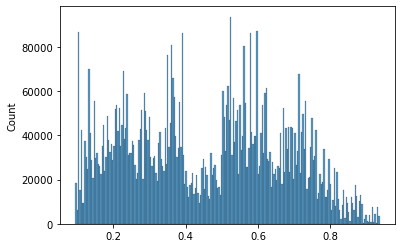

In [225]:
# test_pred = bst.predict(test_x.values)
sns.histplot(test_pred)